In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from DSS_analyzer_Mariner import datareader, Data1D_GAUGE, Data1D_PumpingCurve, Data2D_XT_DSS
# Use this script you should connect to Midland server first.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
stage = 7 # stage = 1 means there would be stage 1,2 plotted in the result. 

# controlling the amplitude of the gauge data.
coeff = 0.2

In [4]:
# dataiov3_path = "../../dataiov3/output/"
dataiov3_path = "./"
pumping_curve_datapath = dataiov3_path + f"prod/pumping_curve/pumping_curve_stage{stage}.npz"
frac_hit_location_path = "../../../../data/Fiber/CWC/POW-S CWC EventTable.xlsx"
lfdas_data_path = dataiov3_path + f"s_well/DASdata/LFDASdata_stg{stage}_swell.npz"
pumping_curve_datapath_next = f"../../dataiov3/output/prod/pumping_curve/pumping_curve_stage{stage+1}.npz"
lfdas_data_interval = f"../../dataiov3/output/s_well/DASdata/LFDASdata_stg{stage}_interval_swell.npz"
lfdas_data_path_next = f"../../dataiov3/output/s_well/DASdata/LFDASdata_stg{stage+1}_swell.npz"
# Load pumping curve data
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_datapath)
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_datapath_next)
DASdata = Data2D_XT_DSS.Data2D()
DASdata.loadnpz(lfdas_data_path)
DASdata_next = Data2D_XT_DSS.Data2D()
DASdata_next.loadnpz(lfdas_data_path_next)
DASdata_interval = Data2D_XT_DSS.Data2D()
DASdata_interval.loadnpz(lfdas_data_interval)
# Merge the DAS data
DASdata_new = Data2D_XT_DSS.merge_data2D([DASdata, DASdata_interval, DASdata_next])
cx = np.array([-1,1])
# fracture hit location detected by the monitoring well
frac_hit_stage_info, frac_hit_depth_info = datareader.event_marina_reader(frac_hit_location_path)
from DSS_analyzer_Mariner import event_analysis_tools
depth_group_info = event_analysis_tools.event_group_generator(frac_hit_stage_info, frac_hit_depth_info)
fracture_hit_depth_data1 = depth_group_info[stage-1]
fracture_hit_depth_data2 = depth_group_info[stage]
from DSS_analyzer_Mariner import Data3D_geometry
gauge_md_dataframe = Data3D_geometry.Data3D_geometry(f"../../dataiov3/output/s_well/geometry/gauge_md_swell.npz")
gauge_md = gauge_md_dataframe.data
ind = np.array(np.where(np.logical_and(gauge_md <=  np.max(fracture_hit_depth_data1) + 500, gauge_md >= np.min(fracture_hit_depth_data2) - 800))).flatten()
from tqdm import tqdm
DASdata_new.cal_timestamp_from_taxis()
start_time_lfdas = DASdata_new.timestamps[0]
end_time_lfdas = DASdata_new.timestamps[-1]
# Load and plot the pressure gauge data
gauge_dataframe_all = []
for iter in tqdm(ind): 
    datapath = f'../../dataiov3/output/s_well/gauge_data/gauge{iter+1}_data_swell.npz'
    gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(datapath)
    gauge_dataframe.crop(start_time_lfdas, end_time_lfdas)
    gauge_dataframe_all.append(gauge_dataframe)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.79s/it]


In [5]:
depth_range = np.array([np.min(fracture_hit_depth_data2) - 800, np.max(fracture_hit_depth_data1) + 500])
DASdata_new.select_depth(depth_range[0], depth_range[1])
from datetime import timedelta

In [6]:
%matplotlib widget

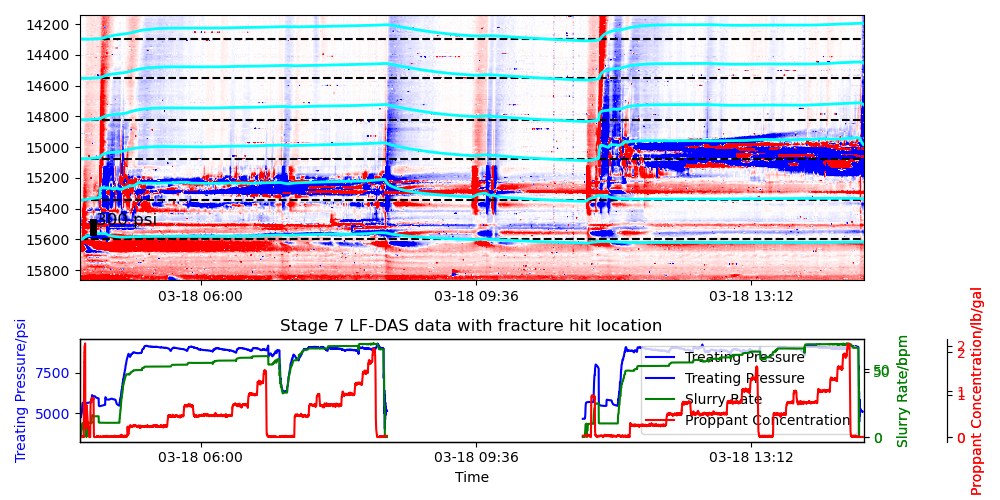

In [7]:
# scalar
tmp_taxis = np.repeat(gauge_dataframe_all[0].taxis[0] + timedelta(minutes=10), 2)
scalar_value = 300
tmp_value = np.array([+ gauge_md[ind][0] - 50, (scalar_value) * - coeff + gauge_md[ind][0] - 50])

plt.figure(figsize=(10, 5))

ax1 = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4)
for i in range(len(gauge_md[ind])):
    ax1.axhline(y=gauge_md[ind][i], color='black', linestyle='--')
    ax1.plot(gauge_dataframe_all[i].taxis, (gauge_dataframe_all[i].data - gauge_dataframe_all[i].data[0]) * - coeff + gauge_md[ind][i], color='cyan', linewidth=2)
ax1.plot(tmp_taxis, tmp_value, color='black', linewidth=5)
ax1.text(tmp_taxis[0] + timedelta(minutes=3), tmp_value[0] - scalar_value/7, f"{scalar_value} psi", fontsize=12, color='black')
img1 = DASdata_new.plot_water_on_ax(ax1, use_timestamp=True)
img1.set_clim(cx * 5e2)

ax2 = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=2, sharex=ax1)
pumping_curve_dataframe.plot_all_vars(ax2)
pumping_curve_dataframe_next.plot_all_vars(ax2)

plt.title(f"Stage {stage} LF-DAS data with fracture hit location")
plt.tight_layout()
plt.show()

I need to design better grid to make the wave not propagating to the boundary.

In [8]:
# Design the grid for the plot
# 1. gauge md, 2. fracture hit location

synthetic_gauge_md = depth_range[1] - gauge_md[ind]

In [9]:
# get the fracture hit location of two stages
frac_hit_depth_data1 = depth_group_info[stage-1]
frac_hit_depth_data2 = depth_group_info[stage]
avg_frac_hit_depth1 = np.mean(frac_hit_depth_data1)
avg_frac_hit_depth2 = np.mean(frac_hit_depth_data2)

synthetic_frac_hit_depth = np.array([depth_range[1] - avg_frac_hit_depth1, depth_range[1] - avg_frac_hit_depth2])

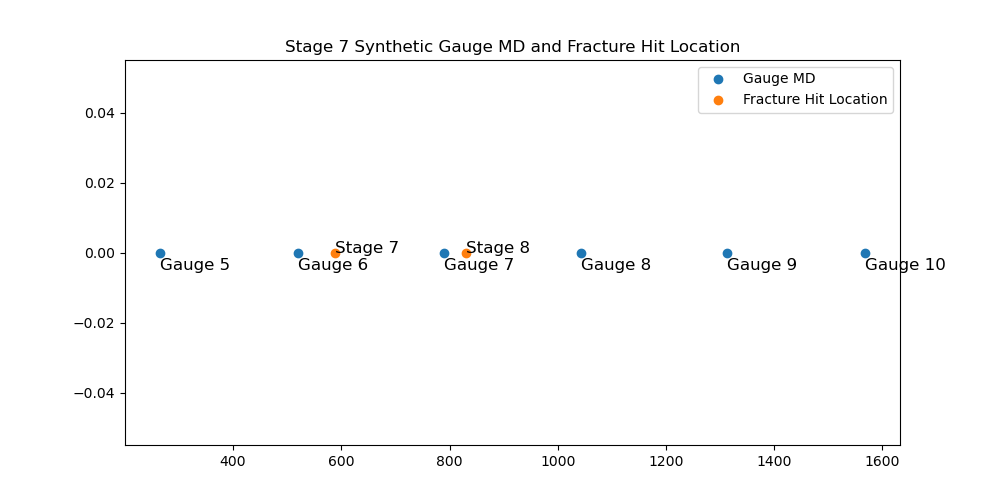

In [10]:
# Plot the synthetic gauge md and fracture hit location in a 1D plot
plt.figure(figsize=(10, 5))
plt.plot(synthetic_gauge_md, np.zeros_like(synthetic_gauge_md), 'o', label='Gauge MD')
# mark the pressure gauge number 
tmp_num = 0
for iter in ind:
    plt.text(synthetic_gauge_md[tmp_num], -0.005, f"Gauge {iter+1}", fontsize=12, color='black')
    tmp_num += 1
plt.plot(synthetic_frac_hit_depth, np.zeros_like(synthetic_frac_hit_depth), 'o', label='Fracture Hit Location')
# mark the stage 1 and stage 2
plt.text(synthetic_frac_hit_depth[0], 0, f"Stage {stage}", fontsize=12, color='black')
plt.text(synthetic_frac_hit_depth[1], 0, f"Stage {stage+1}", fontsize=12, color='black')
plt.legend()
plt.title(f"Stage {stage} Synthetic Gauge MD and Fracture Hit Location")
plt.show()

In [11]:
# New version: 
extend_nx = 2000

nx_old = 1600
nt = 800

dx = 1
dt = 1

In [12]:
x = np.arange(0, nx_old) * dx
t = np.arange(0, nt) * dt

In [13]:
# extend x by add negative value and positive value
x = np.concatenate([x - extend_nx * dx, x, x + extend_nx * dx])

In [14]:
# Convert synthetic gauge md to index
gauge_md_index = np.round(synthetic_gauge_md / dx).astype(int) + extend_nx
frac_hit_index = np.round(synthetic_frac_hit_depth / dx).astype(int) + extend_nx

In [15]:
nx = len(x)
u = np.zeros((nt, nx))

In [16]:
# start and end time of two stages
stg1_start = 100
stg1_end = 250

stg2_start = 500
stg2_end = 650

In [17]:
# diffusivity initialization
initial_diffusivity = 5e2
decay_factor = 0.00001 # should be less than 1
d = np.ones(nx) * initial_diffusivity # ft^2/s

inj_pressure = 1100

In [18]:
# stg 1: 100; stg 2: 500. Do const pressure while during simulation.

# phase 1: before stimulation 
from tqdm import tqdm
for iter in tqdm(range(stg1_start, stg1_end)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    np.fill_diagonal(A, 1 + 2 * alpha)
    np.fill_diagonal(A[1:], -alpha)
    np.fill_diagonal(A[:, 1:], -alpha)

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # Source term
    A[frac_hit_index[0]-5: frac_hit_index[0]+5, :] = 0
    # fill the A matrix
    for iter2 in range(frac_hit_index[0]-5, frac_hit_index[0]+5):
        A[iter2, iter2] = 1
        b[iter2] = inj_pressure
    # A[frac_hit_index[0], :] = 0
    # A[frac_hit_index[0], frac_hit_index[0]] = 1
    # b[frac_hit_index[0]] = 500
    
    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:12<00:00,  2.07it/s]


In [19]:
# phase 2: after stimulation. Before stage 2

# Update the diffusivity
d[frac_hit_index[0]-5: frac_hit_index[0]+5] = d[frac_hit_index[0]-5: frac_hit_index[0]+5] * decay_factor
# d[frac_hit_index[0]] = d[frac_hit_index[0]] * 0.9

# FD simulation
for iter in tqdm(range(stg1_end, stg2_start)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # No source term in this phase

    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:04<00:00,  2.01it/s]


In [20]:
%matplotlib widget

In [21]:
# Phase 3: stage 2 stimulation

for iter in tqdm(range(stg2_start, stg2_end)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # Source term
    A[frac_hit_index[1]-5: frac_hit_index[1]+5, :] = 0
    # fill the A matrix
    for iter2 in range(frac_hit_index[1]-5, frac_hit_index[1]+5):
        A[iter2, iter2] = 1
        b[iter2] = inj_pressure
    # A[frac_hit_index[0], :] = 0
    # A[frac_hit_index[0], frac_hit_index[0]] = 1
    # b[frac_hit_index[0]] = 500
    
    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:13<00:00,  2.03it/s]


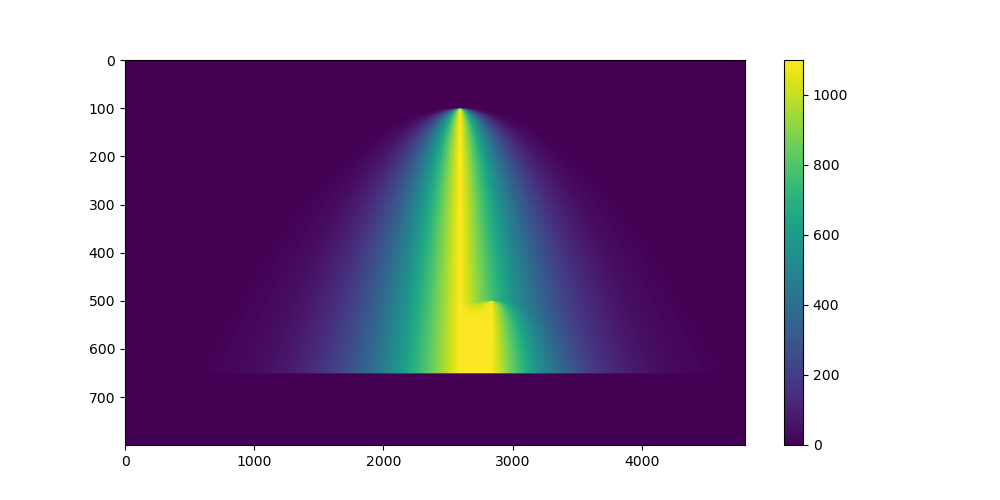

In [22]:
# QC. imshow the u
plt.figure(figsize=(10, 5))
plt.imshow(u, aspect='auto')
plt.colorbar()
plt.show()

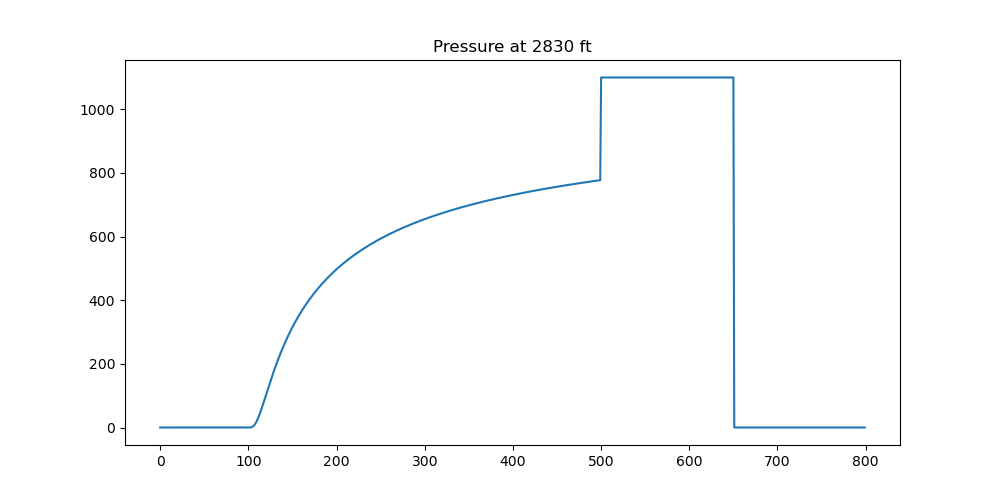

In [23]:
# QC, ind = frac_hit_index[0]
ind = frac_hit_index[1]
plt.figure(figsize=(10, 5))
plt.plot(u[:, ind])
plt.title(f"Pressure at {ind} ft")
plt.show()

In [24]:
# Phase 4: after stage 2 stimulation
# Update the diffusivity
d[frac_hit_index[1]-5: frac_hit_index[1]+5] = d[frac_hit_index[1]-5: frac_hit_index[1]+5] * decay_factor

for iter in tqdm(range(stg2_end, nt-1)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # No source term in this phase

    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:15<00:00,  1.98it/s]


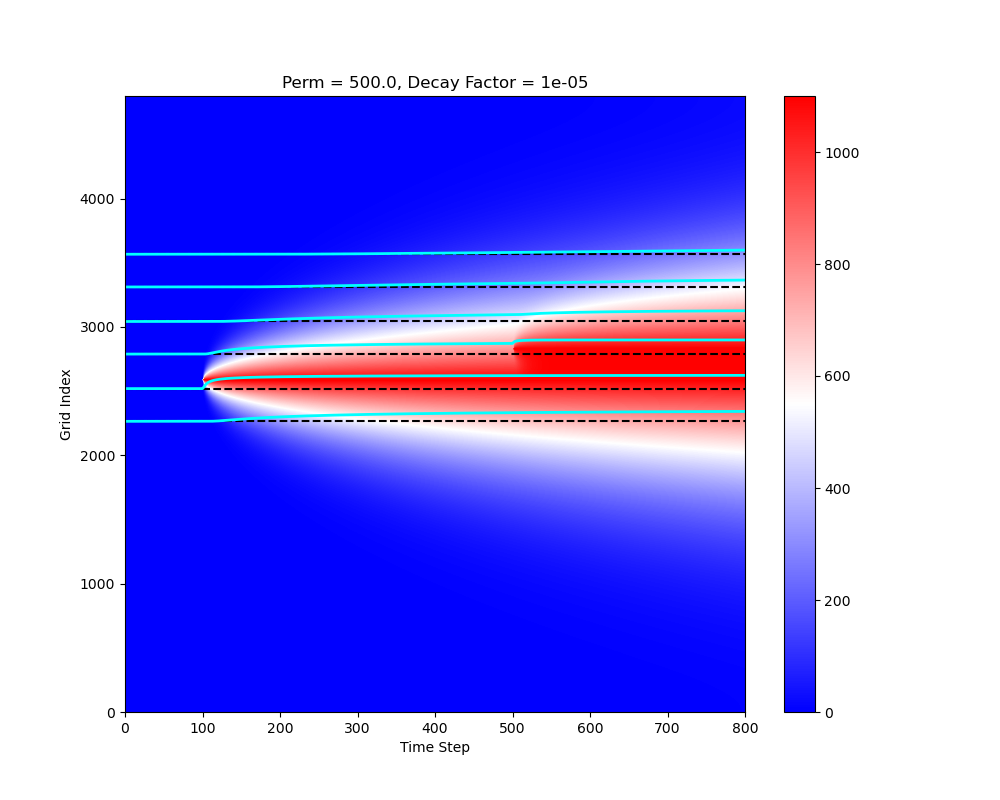

In [25]:
# QC. Show the final result
plt.figure(figsize=(10, 8))
plt.imshow(u.T, aspect='auto', cmap='bwr', extent=[0, nt, nx, 0])
# Set x and y label
plt.xlabel("Time Step")
plt.ylabel("Grid Index")

# Plot the gauge md loc using axhline
for iter in range(len(gauge_md_index)):
    plt.axhline(y=gauge_md_index[iter], color='black', linestyle='--')
    # get the value of u at the gauge md
    plt.plot(t, (u[:, gauge_md_index[iter]] - u[:, gauge_md_index[iter]][0]) * 0.1 + gauge_md_index[iter], color='cyan', linewidth=2)

# invert the y axis
plt.gca().invert_yaxis()

plt.title(f"Perm = {initial_diffusivity}, Decay Factor = {decay_factor}")
plt.colorbar()
plt.show()